<a href="https://colab.research.google.com/github/aarmentamna/machine_learning_advance/blob/main/TC4033_Activity2c_42.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Maestría en Inteligencia Artificial Aplicada**
### **Curso: ADVANCE MACHINE LEARNING METHODS**
## Tecnológico de Monterrey
### Dr. José Antonio Cantoral Ceballos

## Activity Week 4
### **Exploring Transfer Learning with CIFAR-10.**

*TEAM MEMBERS:*

*   Roberto Romero Vielma - A00822314
*   José Javier Granados Hernández - A00556717
*   Aquiles Yonatan Armenta Hernandez - A01793252
*   Alan Avelino Fernández Juárez - A00989308

# TC 5033
## Deep Learning
## Transfer Learning

<br>

#### Activity 2c: Exploring Transfer Learning with CIFAR-10
<br>

- Objective:

    In this activity, you'll study the concept of Transfer Learning, a powerful technique to improve the performance of your models by leveraging pre-trained architectures. The provided notebook offers a complete solution using a specific pre-trained model on the CIFAR-10 dataset. Your task is to extend this by trying out two other pre-trained models.
    
- Instructions:

    This activity should be submitted in the same format as previous activities. Remember to include the names of all team members in a markdown cell at the beginning of the notebook. The grade obtained in this notebook will be averaged with that of Activity 2b, for the grade of Activity 2.    

    Study the Provided Code: The provided notebook has a complete Transfer Learning solution using a particular pre-trained model. Make sure you understand the flow of the code and the role of each component.

    Select Two Other Pre-trained Models: Choose two different pre-trained models available in PyTorch's model zoo.

    Apply Transfer Learning: Add cells to implement Transfer Learning using the two models you've chosen. Train these models on the CIFAR-10 dataset.

    Evaluation: After training, evaluate your models' performance. Compare the results with the provided solution and try to interpret why there might be differences.

    Documentation: In a markdown cell, summarize your findings. Include any challenges you faced, how you overcame them, and any interesting insights you gained from comparing the different pre-trained models.

- Note:

    Although the provided code serves as a guide, you're encouraged to implement the new solutions on your own. The goal is to reinforce your understanding of Transfer Learning and how to apply it effectively.




In [ ]:
# Import necessary libraries
import numpy as np  # Import numpy library and alias it as "np"
import torch  # Import the PyTorch library
import torch.nn as nn  # Import the neural network module from PyTorch
import torch.nn.functional as F # Import functional utilities for PyTorch

# Import data-related modules
from torch.utils.data import DataLoader # Import DataLoader for handling datasets
from torch.utils.data import sampler # Import sampler for custom dataset sampling
import torchvision.datasets as datasets  # Import datasets from the torchvision library
import torchvision.transforms as T # Import data transformation functions from torchvision
from torchvision import models  # Import pre-trained models from torchvision

This code is a Python script that imports several libraries and modules, which are commonly used in machine learning and computer vision tasks. Here's a breakdown of what each part of the code does:

1. `import numpy as np`: Imports the NumPy library and aliases it as `np`. NumPy is widely used for numerical and array operations in Python.

2. `import torch`: Imports the PyTorch library, a popular deep learning framework.

3. `import torch.nn as nn`: Imports the neural network module from PyTorch, which is essential for defining and training neural network models.

4. `import torch.nn.functional as F`: Imports the functional module from PyTorch, which contains various functions for building neural networks.

5. `from torch.utils.data import DataLoader`: Imports the `DataLoader` class from PyTorch's data utility. DataLoaders are used to load and batch data for training machine learning models.

6. `from torch.utils.data import sampler`: Imports the `sampler` module, which can be used to sample data from datasets for training purposes.

7. `import torchvision.datasets as datasets`: Imports the datasets module from torchvision, an extension of PyTorch designed for computer vision tasks. It provides access to common datasets used in computer vision.

8. `import torchvision.transforms as T`: Imports data transformation functions from torchvision, allowing you to preprocess and augment data for computer vision tasks.


In [ ]:
# Import Matplotlib for data visualization
import matplotlib.pyplot as plt  # Import the Matplotlib library and alias it as "plt"

### Download Cifar10 dataset

This code is responsible for downloading, preparing, and loading the CIFAR-10 dataset for machine learning tasks. Here's an explanation of the code:

1. `DATA_PATH` is set to the directory path where CIFAR-10 data will be stored. The variables `NUM_TRAIN`, `NUM_VAL`, `NUM_TEST`, and `MINIBATCH_SIZE` define the sizes of training, validation, and test datasets, as well as the batch size for data loading and processing.

2. A data transformation `transform_cifar` is defined using `torchvision.transforms.Compose`. This transformation converts the images to tensors and normalizes them using specific mean and standard deviation values.

3. Three separate DataLoaders are created for training, validation, and test datasets:
    - `cifar10_train` loads and processes the CIFAR-10 training data with the specified transformation. It uses `SubsetRandomSampler` to select a random subset of the training data.
    - `cifar10_val` loads and processes the CIFAR-10 validation data with the same transformation. It selects a random subset of the validation data using `SubsetRandomSampler`.
    - `cifar10_test` loads and processes the CIFAR-10 test data using the same transformation. It selects a random subset of the test data with `SubsetRandomSampler`.

4. The code checks and prints information about the training data and the batch size for the training loader.

5. A loop iterates through the training array images and enumerates each one, printing the image tensor and its corresponding label.

### Descargar sets de datos

In [ ]:
# Set the path to the CIFAR-10 dataset
# DATA_PATH = '/media/pepe/DataUbuntu/Databases/cifar-10/cifar-10-batches-py'
DATA_PATH = './cifar-10/'
# Define the number of training examples
NUM_TRAIN = 45000
# Define the batch size for training
MINIBATCH_SIZE = 64
# Define a data transformation pipeline for the ImageNet pre-trained model
transform_imagenet = T.Compose([
                T.Resize(224),  # Resize the input images to 224x224 pixels
                T.ToTensor(), # Convert the images to PyTorch tensors
                T.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)) # Normalize the image data
            ])

# Define a data transformation pipeline for the CIFAR-10 dataset
transform_cifar = T.Compose([
                T.ToTensor(), # Convert the images to PyTorch tensors
                T.Normalize([0.491, 0.482, 0.447], [0.247, 0.243, 0.261]) # Normalize the image data
            ])

# Create a DataLoader for the training set
# Training set loader
cifar10_train = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                             transform=transform_imagenet)
train_loader = DataLoader(cifar10_train, batch_size=MINIBATCH_SIZE,
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

# Validation set loader
cifar10_val = datasets.CIFAR10(DATA_PATH, train=True, download=True,
                           transform=transform_imagenet)
val_loader = DataLoader(cifar10_val, batch_size=MINIBATCH_SIZE,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, len(cifar10_val))))

# Create a DataLoader for the testing set
# Testing set loader
cifar10_test = datasets.CIFAR10(DATA_PATH, train=False, download=True,
                            transform=transform_imagenet)
test_loader = DataLoader(cifar10_test, batch_size=MINIBATCH_SIZE)

100%|██████████| 170498071/170498071 [00:12<00:00, 13703913.14it/s]


Extracting ./cifar-10/cifar-10-python.tar.gz to ./cifar-10/
Files already downloaded and verified
Files already downloaded and verified


In [ ]:
# Iterate through the validation data loader and print information about each batch
for i, (x, y) in enumerate(val_loader):
    print(i, x.shape, y.shape)

0 torch.Size([64, 3, 224, 224]) torch.Size([64])
1 torch.Size([64, 3, 224, 224]) torch.Size([64])
2 torch.Size([64, 3, 224, 224]) torch.Size([64])
3 torch.Size([64, 3, 224, 224]) torch.Size([64])
4 torch.Size([64, 3, 224, 224]) torch.Size([64])
5 torch.Size([64, 3, 224, 224]) torch.Size([64])
6 torch.Size([64, 3, 224, 224]) torch.Size([64])
7 torch.Size([64, 3, 224, 224]) torch.Size([64])
8 torch.Size([64, 3, 224, 224]) torch.Size([64])
9 torch.Size([64, 3, 224, 224]) torch.Size([64])
10 torch.Size([64, 3, 224, 224]) torch.Size([64])
11 torch.Size([64, 3, 224, 224]) torch.Size([64])
12 torch.Size([64, 3, 224, 224]) torch.Size([64])
13 torch.Size([64, 3, 224, 224]) torch.Size([64])
14 torch.Size([64, 3, 224, 224]) torch.Size([64])
15 torch.Size([64, 3, 224, 224]) torch.Size([64])
16 torch.Size([64, 3, 224, 224]) torch.Size([64])
17 torch.Size([64, 3, 224, 224]) torch.Size([64])
18 torch.Size([64, 3, 224, 224]) torch.Size([64])
19 torch.Size([64, 3, 224, 224]) torch.Size([64])
20 torch.S

### Usar GPU

In [ ]:
# Check if a CUDA-enabled GPU is available
if torch.cuda.is_available():
    device = torch.device('cuda') # Set the device to CUDA
else:
    device = torch.device('cpu') # Set the device to CPU

# Print the selected device
print(device)

cuda


### Mostrar imágenes
In the next code cell, we will visualize a random image from the test dataset using the provided code. Here's an explanation of the code:

1. `classes = test_loader.dataset.classes`: This line extracts the list of classes provided by the image library. For example, if you are working with the CIFAR-10 dataset, the list will include class names like 'airplane,' 'automobile,' and 'bird.'

2. The `plot_figure` function is defined to display an image. It rearranges the image matrix dimensions to ensure proper display without rotation.

3. `rnd_sample_idx = np.random.randint(len(test_loader))` randomly selects an index to access a random sample from the test dataset.

4. `print(f'The sampled image represents: {classes[test_loader.dataset[rnd_sample_idx][1]]}')` prints the class label of the randomly selected image.

5. The image matrix is retrieved using `test_loader.dataset[rnd_sample_idx][0]`, and its values are normalized to the range [0, 1].

6. `plot_figure(image)` is called to display the selected image using the `plot_figure` function.

### Mostrar imágenes

La imagen muestreada representa un: Frog


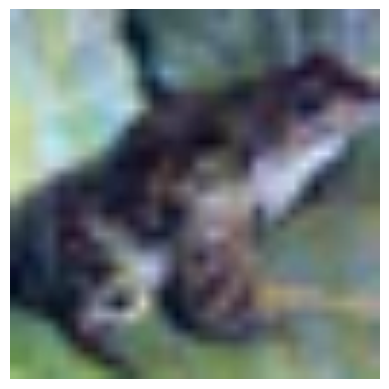

In [ ]:
# List of class labels
classes = ['Plane', 'Car', 'Bird', 'Cat', 'Deer','Dog', 'Frog', 'Horse', 'Ship', 'Truck']

# Function to plot and display an image
def plot_figure(image):
    plt.imshow(image.permute(1,2,0)) # Permute the dimensions for proper display
    plt.axis('off') # Turn off the axis labels and ticks
    plt.show() # Display the image

# Generate a random index to select a sample from the test dataset
rnd_sample_idx = np.random.randint(len(test_loader))
print(f'La imagen muestreada representa un: {classes[test_loader.dataset[rnd_sample_idx][1]]}')

# Retrieve the image and normalize it
image = test_loader.dataset[rnd_sample_idx][0]
image = (image - image.min()) / (image.max() -image.min() )

# Display the image
plot_figure(image)

### Calcular Accuracy

In [ ]:
# This function calculates the accuracy of a model
def accuracy(model, loader):
    num_correct = 0 # Initialize a counter for the number of correctly classified samples
    num_total = 0 # Initialize a counter for the total number of samples
    model.eval()  # Set the model to evaluation mode (disables gradient computation)
    model = model.to(device=device) # Move the model to the selected device (CPU or GPU)

    with torch.no_grad():  # Context for disabling gradient tracking
        for (xi, yi) in loader: # Iterate over batches in the data loader
            xi = xi.to(device=device, dtype = torch.float32) # Move input data to the selected device
            yi = yi.to(device=device, dtype = torch.long)  # Move target labels to the selected device
            scores = model(xi) # mb_size, 10 Forward pass to get the model's predictions (scores)
            _, pred = scores.max(dim=1) #pred shape (mb_size ) Get the class with the highest score as the predicted class
            num_correct += (pred == yi).sum() # pred shape (mb_size), yi shape (mb_size, 1) Count the number of correct predictions in the batch
            num_total += pred.size(0) # Increment the total sample count by the batch size
        return float(num_correct)/num_total  # Calculate and return the accuracy as a floating-point value



### Cargar modelo pre-cargado

# **ResNet**
ResNet (Residual Network) is a family of deep neural network architectures that introduced the concept of residual blocks, which helps address the vanishing gradient problem and enables training of very deep networks. ResNet-18 is one of the smaller variants of the ResNet architecture, which has 18 layers (hence the name) and is commonly used for various computer vision tasks.

In [ ]:
model_resnet18 = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 132MB/s]


#### Exploremos el modelo

In [ ]:
# Iterate through the parameters of the ResNet-18 model
for i, w in enumerate(model_resnet18.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 3, 3]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([64, 64, 3, 3]) True
7 torch.Size([64]) True
8 torch.Size([64]) True
9 torch.Size([64, 64, 3, 3]) True
10 torch.Size([64]) True
11 torch.Size([64]) True
12 torch.Size([64, 64, 3, 3]) True
13 torch.Size([64]) True
14 torch.Size([64]) True
15 torch.Size([128, 64, 3, 3]) True
16 torch.Size([128]) True
17 torch.Size([128]) True
18 torch.Size([128, 128, 3, 3]) True
19 torch.Size([128]) True
20 torch.Size([128]) True
21 torch.Size([128, 64, 1, 1]) True
22 torch.Size([128]) True
23 torch.Size([128]) True
24 torch.Size([128, 128, 3, 3]) True
25 torch.Size([128]) True
26 torch.Size([128]) True
27 torch.Size([128, 128, 3, 3]) True
28 torch.Size([128]) True
29 torch.Size([128]) True
30 torch.Size([256, 128, 3, 3]) True
31 torch.Size([256]) True
32 torch.Size([256]) True
33 torch.Size([256, 256, 3, 3]) True
34 torch.Size([25

In [ ]:
model_resnet18

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

#### Ajustar a nuestro modelo

In [ ]:
# Create a new model 'model_aux' by extracting the layers before the final classification layer
model_aux = nn.Sequential(*list(model_resnet18.children()))
# 'model_aux' now contains the convolutional layers and some intermediate layers of 'model_resnet18'
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
# Create a new model 'model_aux' by extracting all layers from 'model_resnet18' except the last one
model_aux = nn.Sequential(*list(model_resnet18.children())[:-1])

In [ ]:
# 'model_aux' now contains all the layers of 'model_resnet18' up to the final feature extraction layer
model_aux

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
# Iterate through the parameters of 'model_aux' and set requires_grad to False for each parameter
for i, parameter in enumerate(model_aux.parameters()):
    parameter.requires_grad = False

In [ ]:
for i, parameter in enumerate(model_aux.parameters()):
    print(i, parameter.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False


### Loop de entrenamiento
The code below defines a `train` function, which is essential for training a machine learning model. Here's an explanation of the function's role and operation:

- **Objective:** The primary purpose of the `train` function is to facilitate the training of a machine learning model using the specified training data.

- **Device Selection:** The function starts by moving the model to the specified device (CPU or GPU) using `model.to(device=device)`. This ensures that the model is consistently used on the chosen device.

- **Training Loop:** The function performs training over a specified number of training epochs. For each epoch:
    - It iterates through the training data using the `train_loader`.
    - The model is set in training mode using `model.train()` to enable gradient computation and parameter updates.

- **Batch Processing:** For each batch of input data:
    - It moves the input data and target labels to the specified device and data type.
    - The model computes predicted scores for the batch.
    - The cross-entropy loss is calculated using `F.cross_entropy` to quantify the difference between the predicted scores and actual labels.

- **Backpropagation:** The gradients are zeroed using `optimiser.zero_grad()` to prevent accumulation. This is followed by backpropagation (`cost.backward()`) to compute gradients.

- **Parameter Update:** The model's parameters are updated using the optimizer (`optimiser.step()`).

- **Validation Accuracy:** After each epoch, the function calculates the accuracy of the model on the validation set using the `accuracy` function.

- **Progress Reporting:** The function prints information about the training progress, including the current epoch, the cost (loss) for the last batch, and the accuracy on the validation set.

### Loop de entrenamiento

In [ ]:
def train(model, optimiser, epochs=100):
#     def train(model, optimiser, scheduler = None, epochs=100):
    model = model.to(device=device)
    for epoch in range(epochs):
        for i, (xi, yi) in enumerate(train_loader):
            model.train()  # Set the model in training mode
            xi = xi.to(device=device, dtype=torch.float32) # Move input data to the selected device
            yi = yi.to(device=device, dtype=torch.long) # Move target labels to the selected device
            scores = model(xi) # Forward pass to get model predictions

            cost = F.cross_entropy(input= scores, target=yi) # Compute the cross-entropy loss

            optimiser.zero_grad() # Zero out the gradients
            cost.backward() # Backpropagate the gradients
            optimiser.step()  # Update model parameters using the optimizer

        acc = accuracy(model, val_loader) # Calculate accuracy on the validation set
#         if epoch%5 == 0:
        print(f'Epoch: {epoch}, costo: {cost.item()}, accuracy: {acc},')
#         scheduler.step()

In [ ]:
# Define hyperparameters
hidden1 = 256
hidden = 256
lr = 5e-4
epochs = 3
# model1 = nn.Sequential(nn.Flatten(),
#                        nn.Linear(in_features=32*32*3, out_features=hidden1), nn.ReLU(),
#                        nn.Linear(in_features=hidden1, out_features=hidden), nn.ReLU(),
#                        nn.Linear(in_features=hidden, out_features=10))
# Create a neural network model 'model1'
model1 = nn.Sequential(model_aux, # Pre-trained feature extraction layers
                       nn.Flatten(),
                       nn.Linear(in_features=512, out_features= 10, bias= True))
# Define an optimizer (Adam) for the model's parameters
optimiser = torch.optim.Adam(model1.parameters(), lr=lr, betas=(0.9, 0.999))

# train(model1, optimiser, epochs)

In [ ]:
model1

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

### Training the Model and Evaluating Accuracy

In the next 2 code blocks, two important operations are performed:

1. **Training the Model:** The code initiates the training of the model1 neural network. This training is carried out using the train function, which takes the model, optimizer (optimiser), and the specified number of training epochs (epochs) as inputs. During the training process, the model's parameters are adjusted to minimize a defined loss function. This step is fundamental in teaching the model to make accurate predictions on the training data.

2. **Evaluating Accuracy:** After training, the code assesses the performance of the trained model on the test dataset. This is done by invoking the accuracy function, which calculates the accuracy of the model's predictions. It measures the proportion of correctly predicted samples relative to the total number of samples in the test dataset. This accuracy evaluation step provides valuable insights into how well the trained model generalizes to new, unseen data.

In [ ]:
train(model1, optimiser, epochs)

Epoch: 0, costo: 0.6918107271194458, accuracy: 0.774,
Epoch: 1, costo: 0.400554358959198, accuracy: 0.793,
Epoch: 2, costo: 0.40355268120765686, accuracy: 0.7996,


In [ ]:
accuracy(model1, test_loader)

0.7978

# **ResNet-34**
ResNet-34 refers to a specific variant of the ResNet (Residual Network) architecture in deep learning. ResNet is a family of deep neural network models known for its ability to train very deep networks effectively. ResNet-34, in particular, is a ResNet architecture that consists of 34 layers.

The key innovation of ResNet, and the reason for its success, is the use of residual blocks. These blocks contain skip connections (also called identity shortcuts) that allow the gradient to flow more easily during training, addressing the vanishing gradient problem and enabling the training of very deep networks.

## Model with Resnet34

In [ ]:
model_resnet34 = models.resnet34(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 280MB/s]


### Exploring model

In [ ]:
# Iterate through the parameters of the ResNet-34 model
for i, w in enumerate(model_resnet34.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 7, 7]) True
1 torch.Size([64]) True
2 torch.Size([64]) True
3 torch.Size([64, 64, 3, 3]) True
4 torch.Size([64]) True
5 torch.Size([64]) True
6 torch.Size([64, 64, 3, 3]) True
7 torch.Size([64]) True
8 torch.Size([64]) True
9 torch.Size([64, 64, 3, 3]) True
10 torch.Size([64]) True
11 torch.Size([64]) True
12 torch.Size([64, 64, 3, 3]) True
13 torch.Size([64]) True
14 torch.Size([64]) True
15 torch.Size([64, 64, 3, 3]) True
16 torch.Size([64]) True
17 torch.Size([64]) True
18 torch.Size([64, 64, 3, 3]) True
19 torch.Size([64]) True
20 torch.Size([64]) True
21 torch.Size([128, 64, 3, 3]) True
22 torch.Size([128]) True
23 torch.Size([128]) True
24 torch.Size([128, 128, 3, 3]) True
25 torch.Size([128]) True
26 torch.Size([128]) True
27 torch.Size([128, 64, 1, 1]) True
28 torch.Size([128]) True
29 torch.Size([128]) True
30 torch.Size([128, 128, 3, 3]) True
31 torch.Size([128]) True
32 torch.Size([128]) True
33 torch.Size([128, 128, 3, 3]) True
34 torch.Size([128]) True

In [ ]:
model_resnet34

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Fit to our model

In [ ]:
# Create a new model 'model_aux_2' by extracting the layers before the final classification layer
model_aux_2 = nn.Sequential(*list(model_resnet34.children()))
# 'model_aux_2' now contains the convolutional layers and some intermediate layers of 'model_resnet34'
model_aux_2

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
# Create a new model 'model_aux_2' by extracting all layers from 'model_resnet34' except the last one
model_aux_2 = nn.Sequential(*list(model_resnet34.children())[:-1])

In [ ]:
# 'model_aux_2' now contains all the layers of 'model_resnet34' up to the final feature extraction layer
model_aux_2

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
# Iterate through the parameters of 'model_aux_2' and set requires_grad to False for each parameter
for i, parameter in enumerate(model_aux_2.parameters()):
    parameter.requires_grad = False

In [ ]:
for i, parameter in enumerate(model_aux_2.parameters()):
    print(i, parameter.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False
26 False
27 False
28 False
29 False
30 False
31 False
32 False
33 False
34 False
35 False
36 False
37 False
38 False
39 False
40 False
41 False
42 False
43 False
44 False
45 False
46 False
47 False
48 False
49 False
50 False
51 False
52 False
53 False
54 False
55 False
56 False
57 False
58 False
59 False
60 False
61 False
62 False
63 False
64 False
65 False
66 False
67 False
68 False
69 False
70 False
71 False
72 False
73 False
74 False
75 False
76 False
77 False
78 False
79 False
80 False
81 False
82 False
83 False
84 False
85 False
86 False
87 False
88 False
89 False
90 False
91 False
92 False
93 False
94 False
95 False
96 False
97 False
98 False
99 False
100 False
101 False
102 False
103 False
104 False
105 False
106 False
107 False


In [ ]:
# Define hyperparameters
lr = 5e-4
epochs = 3

# Create a neural network model 'model2'
model2 = nn.Sequential(model_aux_2, # Pre-trained feature extraction layers
                       nn.Flatten(),
                       nn.Linear(in_features=512, out_features= 10, bias= True)) # Custom classification layer

# Define an optimizer (Adam) for the model's parameters
optimiser = torch.optim.Adam(model2.parameters(), lr=lr, betas=(0.9, 0.999))


In [ ]:
model2

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  

In [ ]:
train(model2, optimiser, epochs)

Epoch: 0, costo: 0.9035564661026001, accuracy: 0.7924,
Epoch: 1, costo: 0.6500732898712158, accuracy: 0.8056,
Epoch: 2, costo: 0.1970239281654358, accuracy: 0.8084,


In [ ]:
accuracy(model2, test_loader)

0.8052

# **VGG16**
VGG16 is a deep convolutional neural network architecture known for its strong performance in image classification tasks. It was developed by the Visual Geometry Group (VGG) at the University of Oxford and was a runner-up in the 2014 ImageNet Large Scale Visual Recognition Challenge. VGG16 is part of the VGG family of models, which includes various architectures with different depths (e.g., VGG11, VGG19).

## Model with VGG16

In [ ]:
model_vgg16 = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:06<00:00, 85.7MB/s]


In [ ]:
# Iterate through the parameters of the VGG16 model
for i, w in enumerate(model_vgg16.parameters()):
    print(i, w.shape, w.requires_grad)

0 torch.Size([64, 3, 3, 3]) True
1 torch.Size([64]) True
2 torch.Size([64, 64, 3, 3]) True
3 torch.Size([64]) True
4 torch.Size([128, 64, 3, 3]) True
5 torch.Size([128]) True
6 torch.Size([128, 128, 3, 3]) True
7 torch.Size([128]) True
8 torch.Size([256, 128, 3, 3]) True
9 torch.Size([256]) True
10 torch.Size([256, 256, 3, 3]) True
11 torch.Size([256]) True
12 torch.Size([256, 256, 3, 3]) True
13 torch.Size([256]) True
14 torch.Size([512, 256, 3, 3]) True
15 torch.Size([512]) True
16 torch.Size([512, 512, 3, 3]) True
17 torch.Size([512]) True
18 torch.Size([512, 512, 3, 3]) True
19 torch.Size([512]) True
20 torch.Size([512, 512, 3, 3]) True
21 torch.Size([512]) True
22 torch.Size([512, 512, 3, 3]) True
23 torch.Size([512]) True
24 torch.Size([512, 512, 3, 3]) True
25 torch.Size([512]) True
26 torch.Size([4096, 25088]) True
27 torch.Size([4096]) True
28 torch.Size([4096, 4096]) True
29 torch.Size([4096]) True
30 torch.Size([1000, 4096]) True
31 torch.Size([1000]) True


In [ ]:
model_vgg16

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Fit to our model

In [ ]:
# Create a new model 'model_aux_3' by extracting the layers before the final classification layer
model_aux_3 = nn.Sequential(*list(model_vgg16.children()))

# 'model_aux_3' now contains the convolutional layers and some intermediate layers of 'model_vgg16'
model_aux_3

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Create a new model 'model_aux_3' by extracting all layers from 'model_vgg16' except the last one
model_aux_3 = nn.Sequential(*list(model_vgg16.children())[:-1])

# 'model_aux_3' now contains all the layers of 'model_vgg16' up to the final feature extraction layer
model_aux_3

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
# Iterate through the parameters of 'model_aux_3' and set requires_grad to False for each parameter
for i, parameter in enumerate(model_aux_3.parameters()):
    parameter.requires_grad = False

In [ ]:
for i, parameter in enumerate(model_aux_3.parameters()):
    print(i, parameter.requires_grad)

0 False
1 False
2 False
3 False
4 False
5 False
6 False
7 False
8 False
9 False
10 False
11 False
12 False
13 False
14 False
15 False
16 False
17 False
18 False
19 False
20 False
21 False
22 False
23 False
24 False
25 False


In [ ]:
# Define hyperparameters
lr = 5e-4
epochs = 3

# Create a neural network model 'model3'
model3 = nn.Sequential(model_aux_3, # Pre-trained feature extraction layers
                          nn.Flatten(),
                          nn.Linear(in_features=512*7*7, out_features= 10, bias= True))
optimiser = torch.optim.Adam(model3.parameters(), lr=lr, betas=(0.9, 0.999))  # Custom classification layer

In [ ]:
model3

Sequential(
  (0): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): ReLU(inplace=True)
      (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (3): ReLU(inplace=True)
      (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (6): ReLU(inplace=True)
      (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (8): ReLU(inplace=True)
      (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (13): ReLU(inplace=True)
      (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (15): ReLU(inplace=True)
      (16): M

In [ ]:
train(model3, optimiser, epochs)

Epoch: 0, costo: 0.07185742259025574, accuracy: 0.861,
Epoch: 1, costo: 0.0649334192276001, accuracy: 0.8746,
Epoch: 2, costo: 0.08341316133737564, accuracy: 0.8702,


In [ ]:
accuracy(model3, test_loader)

0.8665

# **VGG16:**

*Summary:*

VGG16 is a solid choice for transfer learning in computer vision tasks. Its deep convolutional layers can extract useful features from a wide range of images, and the model is pre-trained on large datasets, making it suitable for various tasks. The architecture is relatively straightforward, with 3x3 convolutions and max-pooling, which simplifies customization. However, its depth can demand significant computational resources.

*Advantages:*
- Effective for transfer learning.
- Straightforward architecture.
- Pre-trained on large datasets.

*Disadvantages:*
- Requires substantial computational resources due to its depth.

# **ResNet34:**

*Summary:*

ResNet34 offers a reliable performance in a broad spectrum of computer vision tasks. It strikes a balance between depth and complexity. ResNet models solve the vanishing gradient problem effectively with residual connections, allowing for deeper training without compromising performance. Like VGG16, it excels in transfer learning and is pre-trained on large datasets.

*Advantages:*
- Effective in a wide range of tasks.
- Addresses vanishing gradient problem.
- Excellent for transfer learning.
- Pre-trained on large datasets.

*Disadvantages:*
- None in particular; it's a versatile choice.

# **ResNet (ResNet18, ResNet34, ResNet50, etc.):**

*Summary:*

ResNet models, including ResNet18 and ResNet34, come in various depths. They are renowned for high performance in computer vision and classification challenges. Their modularity allows for adapting to specific task requirements. They excel in transfer learning and provide flexibility to select the right depth.

*Advantages:*
- Highly diverse in model depth.
- Outstanding performance in a wide array of tasks.
- Excellent for transfer learning.
- Modular and adaptable.

*Disadvantages:*
- None in particular; the choice depends on the specific task and resources available.

**Conclusion:**

Choosing the "best" architecture among VGG16, ResNet34, and the ResNet family depends on the specific project requirements. ResNet models, including ResNet34, are versatile and high-performing. VGG16 is suitable for transfer learning but demands significant computational resources. Overall, ResNet models, including ResNet34, tend to be favored due to their balance between depth and performance, modularity, and the ability to solve gradient vanishing issues. The choice should be made based on the task's complexity and available resources.